Эксперименты(различные датасеты/предобученные модели)

In [1]:
!pip install nltk
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
model_name = "allenai/biomed_roberta_base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
data = data = pd.read_parquet("hf://datasets/gamino/wiki_medical_terms/wiki_medical_terms.parquet")


import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text_with_re(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)
data["cleaned_text"] = data["page_text"].apply(clean_text_with_re)

print(data.head())

def extract_entities_from_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    entities = ner_pipeline(text[:max_length])
    return entities

def build_knowledge_graph(data):
    G = nx.DiGraph()
    for _, row in data.iterrows():
        text = row["cleaned_text"]
        term = row["page_title"]

        entities = extract_entities_from_text(text)
        #print(entities)
        disease = None
        symptoms = []
        treatments = []

        for entity in entities:
          if entity['score'] > 0.58:
            if entity['entity_group'] == 'LABEL_1':
                disease = entity['word']
            elif entity['entity_group'] == 'LABEL_0':
                symptoms.append(entity['word'])
            else:
                treatments.append(entity['word'])

        if disease:
            G.add_node(disease, type='Disease')
            for symptom in symptoms:
                G.add_node(symptom, type='Symptom')
                G.add_edge(disease, symptom, relation="CAUSES")
            for treatment in treatments:
                G.add_node(treatment, type='Treatment')
                G.add_edge(disease, treatment, relation="TREATED_BY")

    return G

import time
start = time.time()
G = build_knowledge_graph(data)
end = time.time()
print("time", end-start)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


                       page_title  \
0           Paracetamol poisoning   
1                      Acromegaly   
2               Actinic keratosis   
3  Congenital adrenal hyperplasia   
4        Adrenocortical carcinoma   

                                           page_text  \
0  Paracetamol poisoning, also known as acetamino...   
1  Acromegaly is a disorder that results from exc...   
2  Actinic keratosis (AK), sometimes called solar...   
3  Congenital adrenal hyperplasia (CAH) is a grou...   
4  Adrenocortical carcinoma  (ACC) is an aggressi...   

                                        cleaned_text  
0  paracetamol poisoning also known acetaminophen...  
1  acromegaly disorder result excess growth hormo...  
2  actinic keratosis ak sometimes called solar ke...  
3  congenital adrenal hyperplasia cah group autos...  
4  adrenocortical carcinoma acc aggressive cancer...  
time 2721.013890504837


In [23]:
nx.write_gexf(G,'biomed_roberta.gexf')

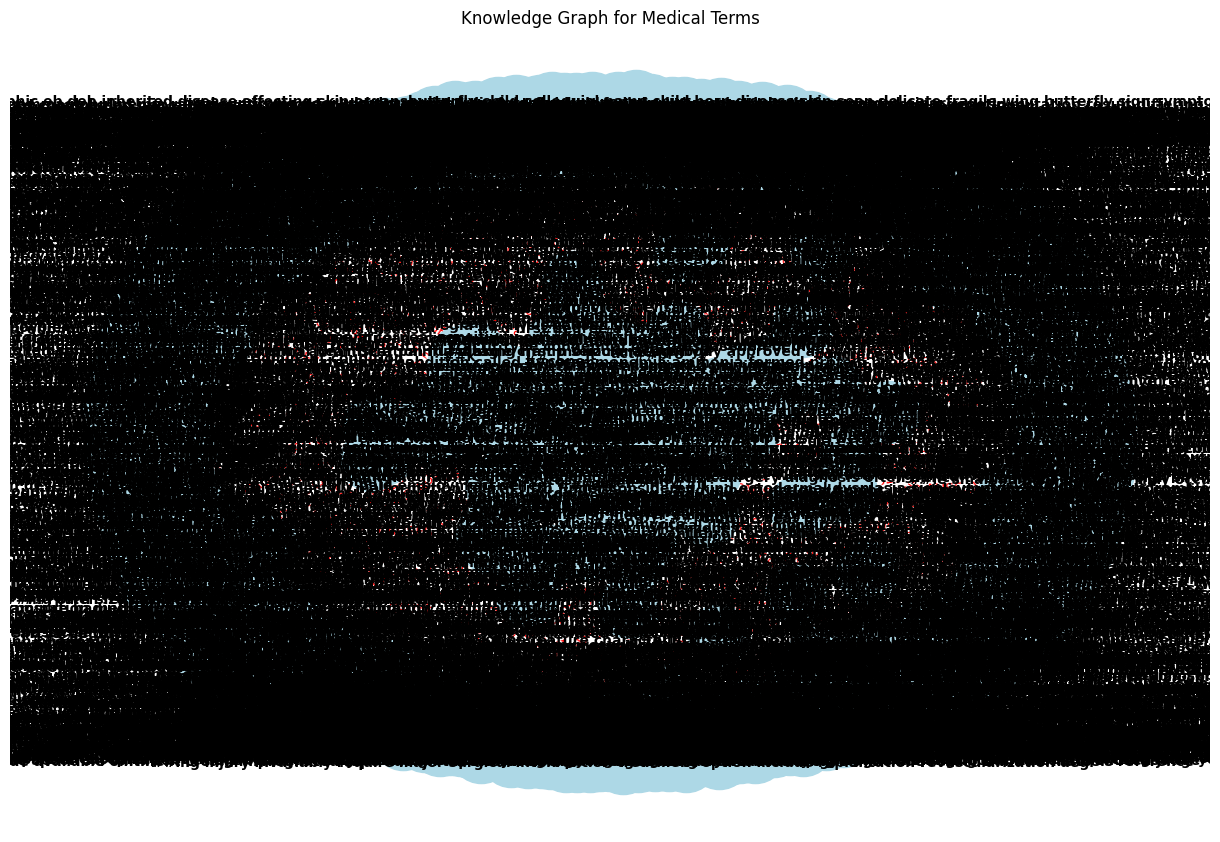

In [15]:

def visualize_graph(G):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    node_labels = {node: node for node in G.nodes}
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")

    edge_labels = nx.get_edge_attributes(G, "relation")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

    plt.title("Knowledge Graph for Medical Terms")
    plt.show()
visualize_graph(G)

In [14]:
# Проверяем количество узлов и рёбер
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

Number of nodes: 1428
Number of edges: 1290
